In [1]:
STACK_LEN          = 400          # desired discriminator FC length
CHUNK              = 100          # generator forward() window  (must divide STACK_LEN)
SUBJ_MAIN          = 18           # main subject
AUGMENT_SUBJECTS   = []           # e.g. [4, 7, 22] to mix others; [] ⇒ single-subject
BATCH_SIM          = 16           # how many fake FCs per simulation pass
BATCH_DISC         = 32           # discriminator mini-batch
EPOCHS_DISC        = 5
GEN_WEIGHTS        = f"weights/gen_sub{SUBJ_MAIN:03d}_g1200_chunk{CHUNK}.pt"
DISC_WEIGHTS_OUT   = f"weights/disc_sub{SUBJ_MAIN:03d}_len{STACK_LEN}.pt"

In [2]:
import os, random, numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path; sns.set_style("white")
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from tqdm import trange
from whobpyt.data_loader import BOLDDataLoader, DEVICE
from simulators.rww_simulator import RWWSubjectSimulator
from whobpyt.models.fc_cnn_disc import FCCNNDisc

Using DEVICE = cuda


In [3]:
assert STACK_LEN % CHUNK == 0, "STACK_LEN must be an integer multiple of CHUNK"
K_STACK = STACK_LEN // CHUNK

DATA_ROOT = "/vol/bitbucket/ank121/fyp/HCP Data"
fmri  = os.path.join(DATA_ROOT, "BOLD Timeseries HCP.mat")
scdir = os.path.join(DATA_ROOT, "distance_matrices")
dist  = os.path.join(DATA_ROOT, "schaefer100_dist.npy")
loader = BOLDDataLoader(fmri, scdir, dist)

[DataLoader] Loaded 100 subjects.


In [4]:
def fc(mat):
    """corrcoef on last dim, numpy -> numpy"""
    return np.corrcoef(mat)

def fc_corr(a,b):
    tri = np.tril_indices_from(a, -1)
    return pearsonr(a[tri], b[tri])[0]


def load_generator(subj):
    sim = torch.load(GEN_WEIGHTS, weights_only=False, map_location=DEVICE)
    sim.model.to(DEVICE).eval()
    print(f"Loaded generator from {GEN_WEIGHTS}")
    print("g  =", sim.model.params.g.val.item())
    print("g_EE =", sim.model.params.g_EE.val.item())
    print("g_EI =", sim.model.params.g_EI.val.item())
    print("g_IE =", sim.model.params.g_IE.val.item())
    print("g_FIC (mean) =", sim.model.params.g_FIC.val.mean().item())
    print("kappa =", sim.model.params.kappa.val.item())
    return sim
sim = load_generator(SUBJ_MAIN)


Loaded generator from weights/gen_sub018_g1200_chunk100.pt
g  = 1200.0330810546875
g_EE = 3.5
g_EI = 1.0639936923980713
g_IE = 0.41999998688697815
g_FIC (mean) = 234.49777221679688
kappa = -0.2863497734069824


In [5]:
def emp_fc_windows(subj):
    ts = loader.all_bold[subj]                         # (N,T)
    N, T = ts.shape
    usable = (T // STACK_LEN) * STACK_LEN
    return [fc(ts[:, i:i+STACK_LEN]) for i in range(0, usable, CHUNK)]

emp_FCs = emp_fc_windows(SUBJ_MAIN)
AUGMENT_SUBJECTS   = [1, 2, 3]
for s in AUGMENT_SUBJECTS:
    emp_FCs += emp_fc_windows(s)
print(f"Collected {len(emp_FCs)} empirical FC-{STACK_LEN} matrices")


Collected 32 empirical FC-400 matrices


In [14]:
# Compute pairwise fc_corr for all pairs in emp_FCs
n = len(emp_FCs)
corr_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        corr_matrix[i, j] = fc_corr(emp_FCs[i], emp_FCs[j])

# Compute mean and std of the off-diagonal fc_corrs
tri = np.tril_indices(n, k=-1)
pairwise_corrs = corr_matrix[tri]
print(f"Mean pairwise fc_corr: {pairwise_corrs.mean():.3f} ± {pairwise_corrs.std():.3f}")



Mean pairwise fc_corr: 0.456 ± 0.096


In [6]:
def sim_fc_batch(sim, batch_size):
    with torch.no_grad():
        out = []
        while len(out) < batch_size:
            ts, _ = sim.simulate(u=0, num_windows=K_STACK, base_window_num=10)
            print(ts.shape)
            out.append(fc(ts))
        return out[:batch_size]

# quick sample to make sure variability is OK
sample_fake = sim_fc_batch(sim, 3)
print("Example fake-vs-fake r:",
      fc_corr(sample_fake[0], sample_fake[1]))

[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
Example fake-vs-fake r: 0.5459912217079737


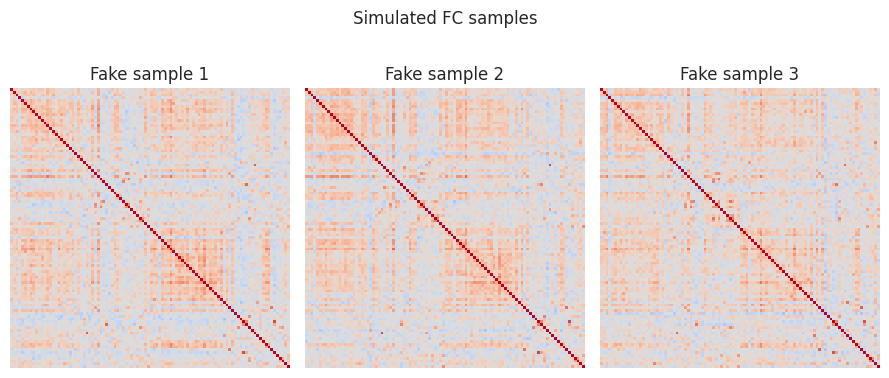

In [7]:
plt.figure(figsize=(9, 4))
for i, fc_mat in enumerate(sample_fake):
    plt.subplot(1, len(sample_fake), i+1)
    sns.heatmap(fc_mat, vmin=-1, vmax=1, cmap="coolwarm", cbar=False, square=True)
    plt.title(f"Fake sample {i+1}")
    plt.axis('off')
plt.suptitle("Simulated FC samples")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [8]:
class FCDataset(Dataset):
    def __init__(self, fc_list, label):
        self.x  = torch.tensor(fc_list, dtype=torch.float32)
        self.x  = self.x.unsqueeze(1)          # (B, 1, N, N)
        self.y  = torch.full((len(fc_list),1), float(label))
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

real_ds = FCDataset(emp_FCs, 1)
# build fake set to roughly match size of real
fake_ds = FCDataset([fc for _ in range((len(real_ds)//BATCH_SIM)+1)
                           for fc in sim_fc_batch(sim, BATCH_SIM)],
                    0)
print(f"fake set size   : {len(fake_ds)}")
print(f"real set size   : {len(real_ds)}")

train_loader = DataLoader(torch.utils.data.ConcatDataset([real_ds, fake_ds]),
                          batch_size=BATCH_DISC, shuffle=True, drop_last=True)



/tmp/ipykernel_3160767/4113936024.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.x  = torch.tensor(fc_list, dtype=torch.float32)


[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator

In [9]:
disc = FCCNNDisc(sim.model.node_size).to(DEVICE)
opt  = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=(0.5,0.999))
bce  = torch.nn.BCELoss()
EPOCHS_DISC = 30
print(len(train_loader))
for ep in range(EPOCHS_DISC):
    disc.train()
    pbar = trange(len(train_loader), desc=f"epoch {ep+1}/{EPOCHS_DISC}", leave=False)
    for xb,yb in train_loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        loss = bce(disc(xb), yb)
        loss.backward(); opt.step()
        # print(f"E{ep} loss={loss.item():.4f}")
        pbar.set_postfix(loss=f"{loss.item():.3f}")


2


[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 


(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)


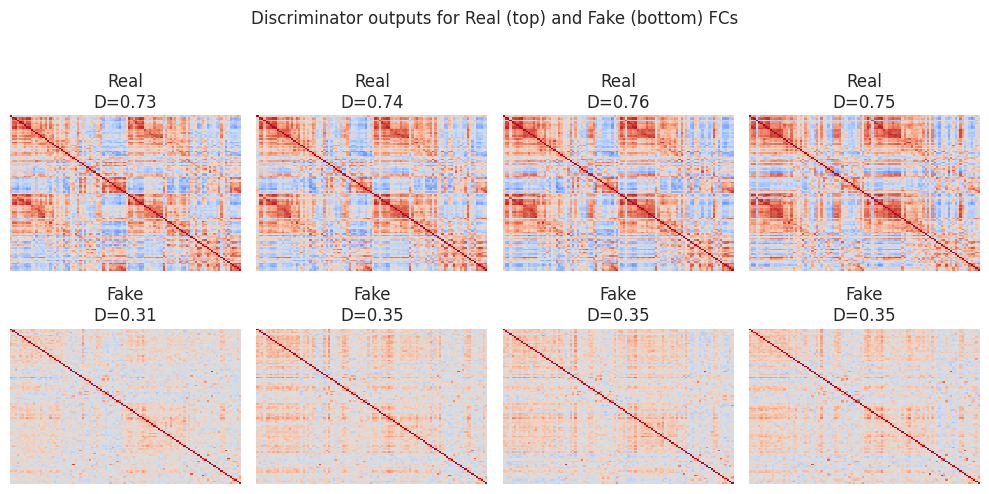

In [10]:
disc.eval()
# test_fake = torch.tensor(sim_fc_batch(sim, 32), dtype=torch.float32).unsqueeze(1).to(DEVICE)
# print("mean p(fake)  on new sims :", disc(test_fake).mean().item())
# test_real = real_ds.x[:32].to(DEVICE)
# print("mean p(real)  on held emp :", disc(test_real).mean().item())

def viz_disc_outputs(num_examples=4):
    disc.eval()
    # Get real and fake examples
    real_examples = real_ds.x[:num_examples].to(DEVICE)
    fake_examples = torch.tensor(sim_fc_batch(sim, num_examples), dtype=torch.float32).unsqueeze(1).to(DEVICE)
    # Get discriminator outputs
    with torch.no_grad():
        real_scores = disc(real_examples).cpu().numpy().flatten()
        fake_scores = disc(fake_examples).cpu().numpy().flatten()
    # Plot
    fig, ax = plt.subplots(2, num_examples, figsize=(2.5*num_examples, 5))
    v = dict(vmin=-1, vmax=1, cmap="coolwarm")
    for i in range(num_examples):
        # Real
        mat_real = real_examples[i,0].cpu().numpy()
        sns.heatmap(mat_real, ax=ax[0,i], **v, cbar=False)
        ax[0,i].set_title(f"Real\nD={real_scores[i]:.2f}")
        ax[0,i].axis('off')
        # Fake
        mat_fake = fake_examples[i,0].cpu().numpy()
        sns.heatmap(mat_fake, ax=ax[1,i], **v, cbar=False)
        ax[1,i].set_title(f"Fake\nD={fake_scores[i]:.2f}")
        ax[1,i].axis('off')
    plt.suptitle("Discriminator outputs for Real (top) and Fake (bottom) FCs")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

viz_disc_outputs()



In [11]:
Path(DISC_WEIGHTS_OUT).parent.mkdir(parents=True, exist_ok=True)
torch.save(disc.state_dict(), DISC_WEIGHTS_OUT)
print(f"Discriminator saved  →  {DISC_WEIGHTS_OUT}")


Discriminator saved  →  weights/disc_sub018_len400.pt


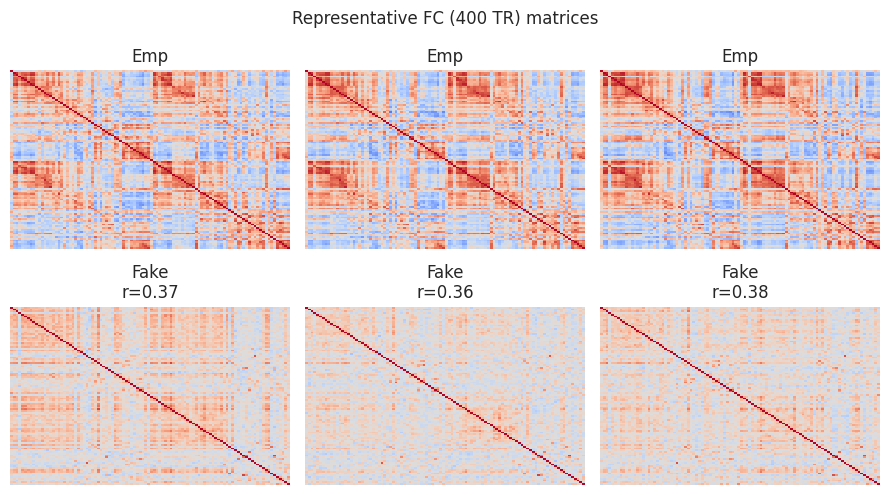

In [25]:
def viz_examples():
    fig,ax = plt.subplots(2,3, figsize=(9,5))
    v = dict(vmin=-1,vmax=1,cmap="coolwarm")
    for i in range(3):
        emp = real_ds.x[i,0].numpy(); fak = fake_ds.x[i,0].numpy()
        r_e = fc_corr(emp, fak)
        sns.heatmap(emp, ax=ax[0,i], **v, cbar=False); ax[0,i].set_title("Emp")
        sns.heatmap(fak, ax=ax[1,i], **v, cbar=False); ax[1,i].set_title(f"Fake\nr={r_e:.2f}")
        [a.axis('off') for a in ax[:,i]]
    plt.suptitle("Representative FC (400 TR) matrices"); plt.tight_layout(); plt.show()
viz_examples()
